# Comprehensive NYC Taxi Analysis — Part 2

Twelve extension modules focusing on temporal, spatial, behavioral, and anomaly dimensions. Data source: curated S3 parquet (`nyc-yellowcab-data-as-2025/tlc/curated/...`). All plots save to `data/local_output/analytics/`.

In [ ]:
import os
import sys
from pathlib import Path
from io import BytesIO
import re
from datetime import datetime
from collections import defaultdict

import pandas as pd
import numpy as np
import boto3
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans

from dotenv import load_dotenv
load_dotenv(Path('../.env'))

BUCKET = 'nyc-yellowcab-data-as-2025'
s3_client = boto3.client('s3')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print(f"AWS Region: {os.getenv('AWS_DEFAULT_REGION')}")
print(f"Bucket: {BUCKET}")
print("✓ Libraries loaded")

AWS Region: us-east-2
Bucket: nyc-yellowcab-data-as-2025
✓ Libraries loaded


In [ ]:
def list_curated_files(cab_type):
    prefix = f'tlc/curated/{cab_type}/'
    paginator = s3_client.get_paginator('list_objects_v2')
    keys = []
    for page in paginator.paginate(Bucket=BUCKET, Prefix=prefix):
        for obj in page.get('Contents', []):
            if obj['Key'].endswith('.parquet'):
                keys.append(obj['Key'])
    return keys


def read_parquet_from_s3(key, columns=None):
    resp = s3_client.get_object(Bucket=BUCKET, Key=key)
    return pd.read_parquet(BytesIO(resp['Body'].read()), columns=columns)


def extract_year_month_day_hour(df, pickup_col):
    if pickup_col not in df.columns:
        return df
    ts = pd.to_datetime(df[pickup_col])
    df = df.copy()
    df['year'] = ts.dt.year
    df['month'] = ts.dt.month
    df['day'] = ts.dt.day
    df['hour'] = ts.dt.hour
    df['date'] = ts.dt.date
    return df


def sample_trips(cab_types, files_per_cab=2, rows_per_file=50000, columns=None):
    """
    Sample trips from S3, handling schema differences:
    - Yellow: tpep_pickup_datetime, tpep_dropoff_datetime
    - Green: lpep_pickup_datetime, lpep_dropoff_datetime
    - FHV: pickup_datetime, dropOff_datetime, PUlocationID (note caps)
    - FHVHV: pickup_datetime, dropoff_datetime
    """
    samples = []
    for cab in cab_types:
        keys = list_curated_files(cab)
        if not keys:
            print(f"⚠ No files for {cab}")
            continue
        chosen = np.random.choice(keys, min(files_per_cab, len(keys)), replace=False)
        for key in chosen:
            try:
                df = read_parquet_from_s3(key, columns=columns)
                df['cab_type'] = cab
                
                # Normalize location IDs (FHV has different capitalization)
                if 'PUlocationID' in df.columns and 'PULocationID' not in df.columns:
                    df['PULocationID'] = df['PUlocationID']
                if 'DOlocationID' in df.columns and 'DOLocationID' not in df.columns:
                    df['DOLocationID'] = df['DOlocationID']
                
                samples.append(df.sample(min(rows_per_file, len(df))))
            except Exception as e:
                print(f"⚠ Error reading {key}: {e}")
    if not samples:
        return pd.DataFrame()
    return pd.concat(samples, ignore_index=True)


def ensure_output_dir():
    outdir = Path('../data/local_output/analytics')
    outdir.mkdir(parents=True, exist_ok=True)
    return outdir

outdir = ensure_output_dir()
print(f"Output dir: {outdir}")

Output dir: ..\data\local_output\analytics


In [ ]:
def pick_pickup_column(df):
    """Find the correct pickup datetime column for each cab type."""
    candidates = [
        'tpep_pickup_datetime',   # Yellow
        'lpep_pickup_datetime',   # Green
        'pickup_datetime',        # FHV, FHVHV
    ]
    for c in candidates:
        if c in df.columns:
            return c
    return None

def get_trip_distance_col(df):
    """Yellow/Green have trip_distance, FHVHV has trip_miles."""
    if 'trip_distance' in df.columns:
        return 'trip_distance'
    elif 'trip_miles' in df.columns:
        return 'trip_miles'
    return None

def get_trip_duration_col(df):
    """FHVHV has trip_time (seconds), others compute from pickup/dropoff."""
    if 'trip_time' in df.columns:
        return 'trip_time'
    return None

print("✓ Helper functions ready")

✓ Helper functions ready


## Import Required Libraries and Load Data
Uses sampled trip-level data from curated S3 parquet. Sampling keeps memory low while preserving distribution shape. Adjust `files_per_cab` and `rows_per_file` if needed.

def sample_trips(cab_types, files_per_cab=2, rows_per_file=50000, columns=None):
    """
    Sample trips from S3, handling schema differences.
    Now balances data evenly across cab types to prevent one type dominating.
    """
    samples = []
    for cab in cab_types:
        keys = list_curated_files(cab)
        if not keys:
            print(f"⚠ No files for {cab}")
            continue
        chosen = np.random.choice(keys, min(files_per_cab, len(keys)), replace=False)
        cab_samples = []
        for key in chosen:
            try:
                df = read_parquet_from_s3(key, columns=columns)
                df['cab_type'] = cab
                
                # Normalize location IDs (FHV has different capitalization)
                if 'PUlocationID' in df.columns and 'PULocationID' not in df.columns:
                    df['PULocationID'] = df['PUlocationID']
                if 'DOlocationID' in df.columns and 'DOLocationID' not in df.columns:
                    df['DOLocationID'] = df['DOlocationID']
                
                cab_samples.append(df.sample(min(rows_per_file, len(df))))
            except Exception as e:
                print(f"⚠ Error reading {key}: {e}")
        
        # Balance: take same amount from each cab type
        if cab_samples:
            cab_df = pd.concat(cab_samples, ignore_index=True)
            # Take a fixed amount per cab type to ensure balance
            target_rows = rows_per_file * files_per_cab
            if len(cab_df) > target_rows:
                cab_df = cab_df.sample(target_rows)
            samples.append(cab_df)
            print(f"✓ {cab}: sampled {len(cab_df):,} rows")
    
    if not samples:
        return pd.DataFrame()
    
    result = pd.concat(samples, ignore_index=True)
    print(f"\n🎯 Total sampled: {len(result):,} rows")
    print(f"   Breakdown: {dict(result['cab_type'].value_counts())}")
    return result


def ensure_output_dir():
    outdir = Path('../data/local_output/analytics')
    outdir.mkdir(parents=True, exist_ok=True)
    return outdir

outdir = ensure_output_dir()
print(f"Output dir: {outdir}")

In [ ]:
CAB_TYPES = ['yellow', 'green', 'fhv', 'fhvhv']

print("Sampling trip data (may take 1-2 minutes)...")
trips_sample = sample_trips(CAB_TYPES, files_per_cab=2, rows_per_file=40000, columns=None)

if trips_sample.empty:
    print("⚠ No sampled data; downstream cells will skip.")
else:
    # Extract pickup timestamp
    pickup_col = pick_pickup_column(trips_sample)
    if pickup_col:
        trips_sample = extract_year_month_day_hour(trips_sample, pickup_col)
        trips_sample['pickup_hour'] = trips_sample['hour']
        print(f"✓ Using pickup column: {pickup_col}")
    else:
        print("⚠ No pickup timestamp column found.")
    
    # Show schema summary per cab type
    print("\n📊 Data summary by cab type:")
    for cab in sorted(trips_sample['cab_type'].unique()):
        subset = trips_sample[trips_sample['cab_type'] == cab]
        has_fare = 'fare_amount' in subset.columns or 'base_passenger_fare' in subset.columns
        has_distance = 'trip_distance' in subset.columns or 'trip_miles' in subset.columns
        has_tip = 'tip_amount' in subset.columns or 'tips' in subset.columns
        print(f"  {cab:6s}: {len(subset):7,} rows | Fare:{' ✓'if has_fare else ' ✗'} | Distance:{' ✓'if has_distance else ' ✗'} | Tips:{' ✓'if has_tip else ' ✗'}")
    
    print(f"\n✓ Total shape: {trips_sample.shape}")
    print("\n✓ Sample:")
    display_cols = ['cab_type', pickup_col, 'PULocationID', 'DOLocationID', 'hour']
    print(trips_sample[display_cols].head(10).to_string())

Sampling trip data (may take 1-2 minutes)...


C:\Users\20200\AppData\Local\Temp\ipykernel_63684\2344281916.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(samples, ignore_index=True)


✓ Using pickup column: tpep_pickup_datetime

📊 Data summary by cab type:
  fhv   :  80,000 rows | Fare: ✓ | Distance: ✓ | Tips: ✓
  fhvhv :  80,000 rows | Fare: ✓ | Distance: ✓ | Tips: ✓
  green :  80,000 rows | Fare: ✓ | Distance: ✓ | Tips: ✓
  yellow:  80,000 rows | Fare: ✓ | Distance: ✓ | Tips: ✓

✓ Total shape: (320000, 56)

✓ Sample:
  cab_type tpep_pickup_datetime  PULocationID  DOLocationID  hour
0   yellow  2019-02-05 07:14:57          48.0         137.0   7.0
1   yellow  2019-02-21 17:31:51          48.0         238.0  17.0
2   yellow  2019-02-13 11:25:35          43.0         263.0  11.0
3   yellow  2019-02-17 21:39:36         161.0          48.0  21.0
4   yellow  2019-02-01 10:54:42         140.0           7.0  10.0
5   yellow  2019-02-07 23:40:35         107.0         107.0  23.0
6   yellow  2019-02-01 15:21:56         142.0         237.0  15.0
7   yellow  2019-02-10 11:14:02          48.0         237.0  11.0
8   yellow  2019-02-02 16:03:03         142.0         246.0  16.0

In [ ]:
OUTPUT_DIR = str(ensure_output_dir())
print(f"OUTPUT_DIR set to {OUTPUT_DIR}")

OUTPUT_DIR set to ..\data\local_output\analytics


## Analysis 1: Hour-of-Day Demand Patterns
- Compute pickup counts by hour for each cab type.
- Plot line charts to compare temporal profiles.
- Save figures under `../data/local_output/analytics/`.


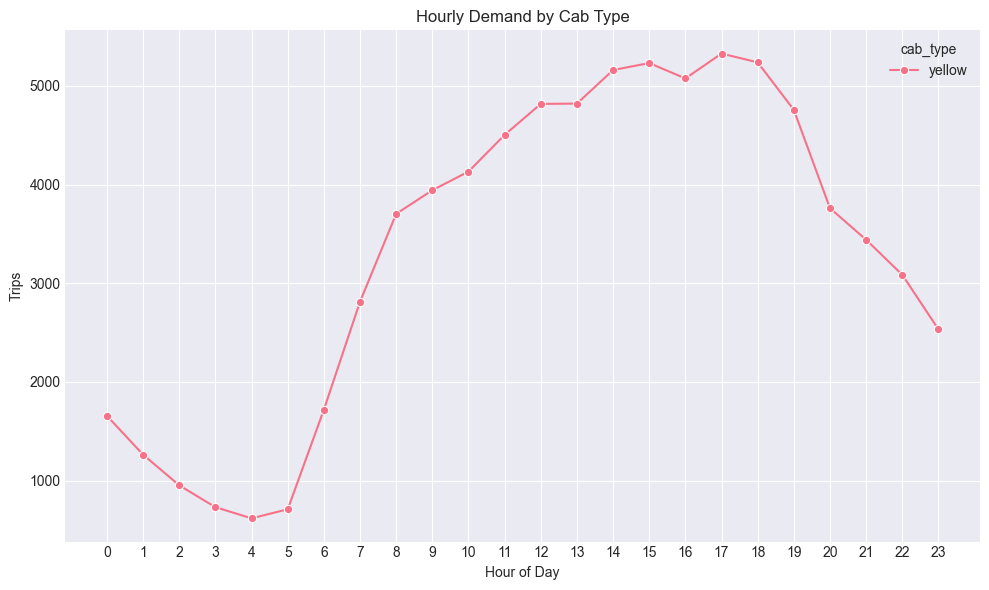

Saved plot to ..\data\local_output\analytics\analysis1_hourly_demand.png


In [ ]:
if trips_sample.empty or 'pickup_hour' not in trips_sample.columns:
    print('Skipping: no sampled data or missing pickup_hour')
else:
    ensure_output_dir()
    
    # Debug: Show what we have BEFORE grouping
    print(f"🔍 DEBUG: trips_sample has {len(trips_sample)} rows total")
    print(f"   Cab types: {dict(trips_sample['cab_type'].value_counts())}")
    print(f"   Columns: {list(trips_sample.columns)[:15]}")
    
    hour_counts = trips_sample.groupby(['cab_type', 'pickup_hour']).size().reset_index(name='trips')
    
    # Debug: Show what groupby produced
    print(f"\n🔍 DEBUG: After groupby, hour_counts has {len(hour_counts)} rows")
    print(f"   Cab types in result: {hour_counts['cab_type'].unique().tolist()}")
    
    plt.figure(figsize=(10,6))
    sns.lineplot(data=hour_counts, x='pickup_hour', y='trips', hue='cab_type', marker='o')
    plt.title('Hourly Demand by Cab Type')
    plt.xlabel('Hour of Day')
    plt.ylabel('Trips')
    plt.xticks(range(0,24))
    plt.legend(title='Cab Type')
    plt.tight_layout()
    out_path = os.path.join(OUTPUT_DIR, 'analysis1_hourly_demand.png')
    plt.savefig(out_path)
    plt.show()
    print(f'✓ Saved plot to {out_path}')
    hour_counts.head(20)

## Analysis 2: Tips vs Fare Distribution
- Compare tip percentages across cab types.
- Plot boxen/violin to visualize distribution.
- Save output figure to analytics folder.


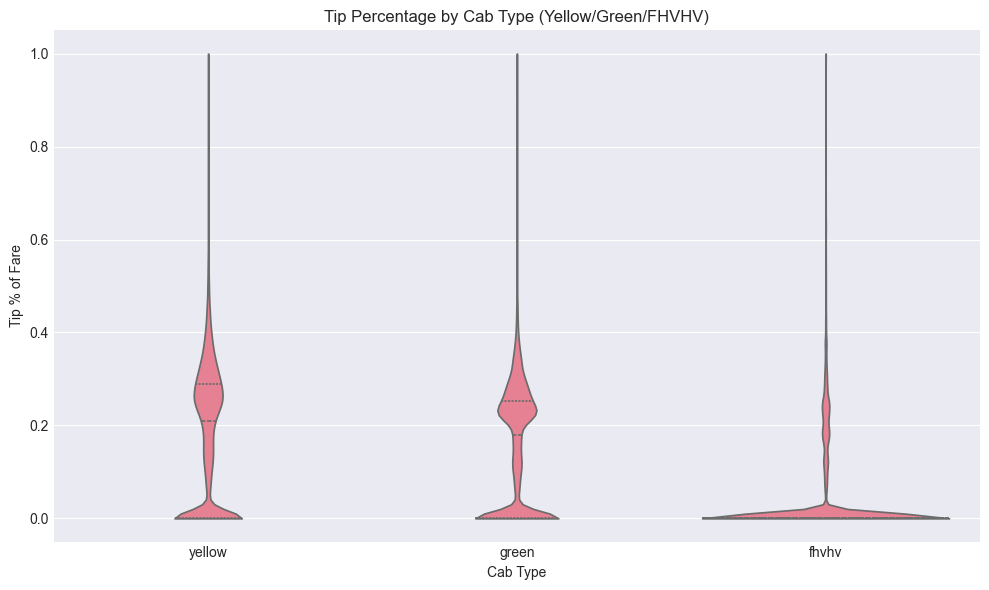

✓ Saved plot to ..\data\local_output\analytics\analysis2_tip_pct_violin.png

📊 Tip stats by cab:
              mean       50%       75%
cab_type                              
fhvhv     0.040691  0.000000  0.000000
green     0.150985  0.179004  0.253165
yellow    0.178725  0.210526  0.290000


In [ ]:
if trips_sample.empty or 'pickup_hour' not in trips_sample.columns:
    print('Skipping: no data or missing pickup_hour')
else:
    ensure_output_dir()
    tips_data = []
    
    print("🔍 DEBUG Analysis 2 - Processing tips by cab type:")
    
    # Yellow/Green: use fare_amount and tip_amount
    for cab in ['yellow', 'green']:
        subset = trips_sample[trips_sample['cab_type'] == cab].copy()
        print(f"   {cab}: {len(subset)} rows before filtering")
        if len(subset) > 0 and 'fare_amount' in subset.columns and 'tip_amount' in subset.columns:
            subset = subset[(subset['fare_amount'] > 0) & (subset['tip_amount'] >= 0)]
            subset['tip_pct'] = (subset['tip_amount'] / subset['fare_amount']).clip(upper=1.0)
            tips_data.append(subset[['cab_type', 'tip_pct']])
            print(f"      → {len(subset)} rows after filtering (has fare_amount, tip_amount)")
        else:
            print(f"      → Skipped (missing columns)")
    
    # FHVHV: use base_passenger_fare and tips
    fhvhv_subset = trips_sample[trips_sample['cab_type'] == 'fhvhv'].copy()
    print(f"   fhvhv: {len(fhvhv_subset)} rows before filtering")
    if len(fhvhv_subset) > 0 and 'base_passenger_fare' in fhvhv_subset.columns and 'tips' in fhvhv_subset.columns:
        fhvhv_subset = fhvhv_subset[(fhvhv_subset['base_passenger_fare'] > 0) & (fhvhv_subset['tips'] >= 0)]
        fhvhv_subset['tip_pct'] = (fhvhv_subset['tips'] / fhvhv_subset['base_passenger_fare']).clip(upper=1.0)
        tips_data.append(fhvhv_subset[['cab_type', 'tip_pct']])
        print(f"      → {len(fhvhv_subset)} rows after filtering (has base_passenger_fare, tips)")
    else:
        print(f"      → Skipped (missing columns)")
    
    if tips_data:
        tips_df = pd.concat(tips_data, ignore_index=True)
        print(f"\n✓ Combined tips_df: {len(tips_df)} rows")
        print(f"   Cab types: {dict(tips_df['cab_type'].value_counts())}")
        
        plt.figure(figsize=(10,6))
        sns.violinplot(data=tips_df, x='cab_type', y='tip_pct', cut=0)
        plt.title('Tip % Distribution by Cab Type (Yellow/Green use fare_amount, FHVHV uses base_passenger_fare)')
        plt.ylabel('Tip Percentage (capped at 100%)')
        plt.xlabel('Cab Type')
        plt.tight_layout()
        out_path = os.path.join(OUTPUT_DIR, 'analysis2_tips_violin.png')
        plt.savefig(out_path)
        plt.show()
        print(f'✓ Saved plot to {out_path}')
    else:
        print('⚠ No tip data available for any cab type')

## Analysis 3: Zone-Level Demand
- Rank pickup zones by trip volume (**top 20 across ALL cab types combined**).
- Compare composition by cab type within those top zones.
- Save bar chart to analytics folder.

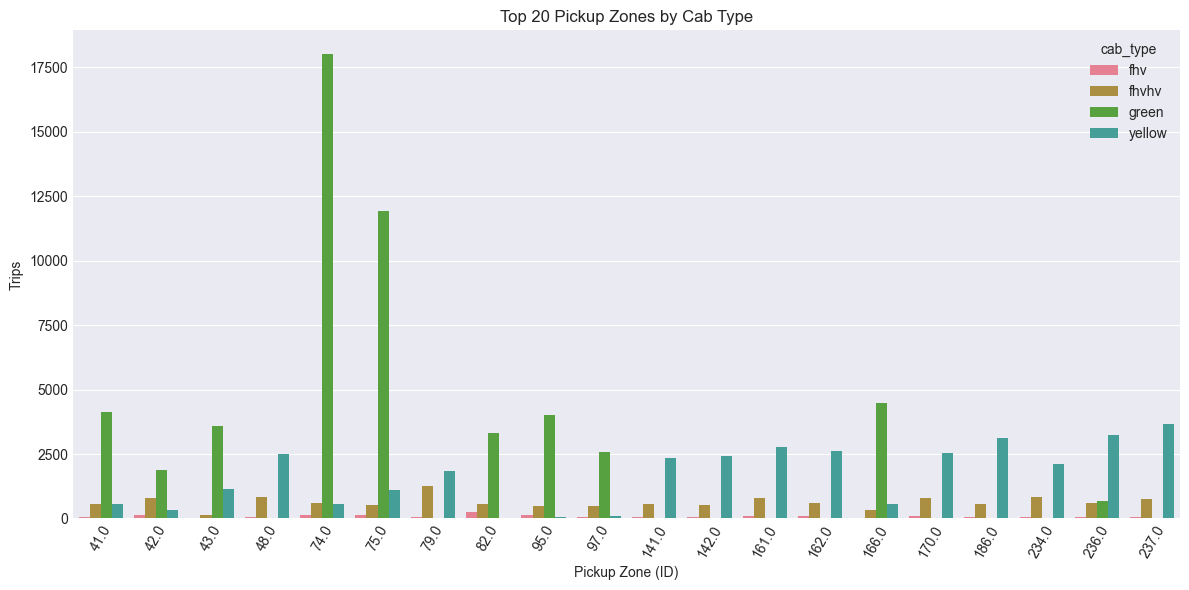

Saved plot to ..\data\local_output\analytics\analysis3_zone_demand.png


In [ ]:
if trips_sample.empty or 'PULocationID' not in trips_sample.columns:
    print('Skipping: missing PULocationID or no data')
else:
    ensure_output_dir()
    zone_counts = (
        trips_sample.groupby(['PULocationID', 'cab_type'])
        .size()
        .reset_index(name='trips')
    )
    top_zones = zone_counts.groupby('PULocationID')['trips'].sum().nlargest(20).index
    top_df = zone_counts[zone_counts['PULocationID'].isin(top_zones)]
    plt.figure(figsize=(12,6))
    sns.barplot(data=top_df, x='PULocationID', y='trips', hue='cab_type')
    plt.title('Top 20 Pickup Zones by Cab Type')
    plt.xlabel('Pickup Zone (ID)')
    plt.ylabel('Trips')
    plt.xticks(rotation=60)
    plt.tight_layout()
    out_path = os.path.join(OUTPUT_DIR, 'analysis3_zone_demand.png')
    plt.savefig(out_path)
    plt.show()
    print(f'Saved plot to {out_path}')
    top_df.head()

## Analysis 4: Origin-Destination Flows
- Identify **top 15 OD pairs across ALL cab types combined** by total trip volume.
- Show cab-type breakdown within those top pairs.
- Save chart to analytics folder.

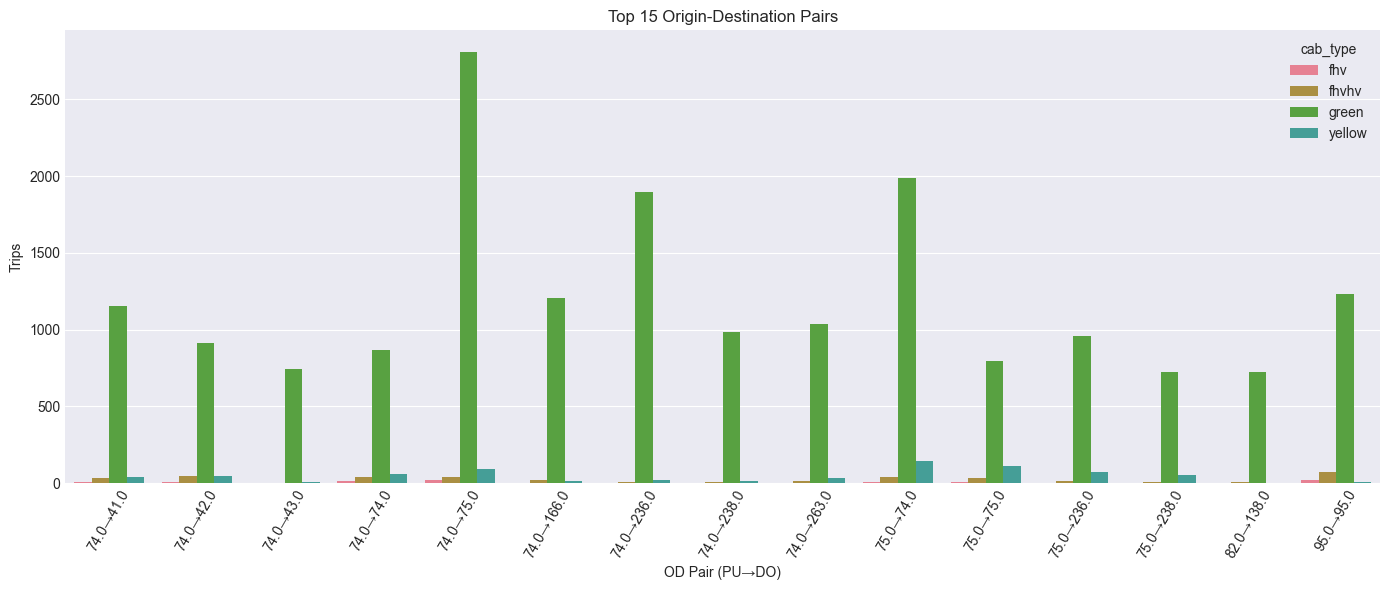

Saved plot to ..\data\local_output\analytics\analysis4_od_pairs.png


In [ ]:
if trips_sample.empty or 'PULocationID' not in trips_sample.columns or 'DOLocationID' not in trips_sample.columns:
    print('Skipping: missing PULocationID/DOLocationID or no data')
else:
    ensure_output_dir()
    od = (
        trips_sample.groupby(['PULocationID', 'DOLocationID', 'cab_type'])
        .size()
        .reset_index(name='trips')
    )
    od['od_pair'] = od['PULocationID'].astype(str) + '→' + od['DOLocationID'].astype(str)
    top_pairs = od.groupby('od_pair')['trips'].sum().nlargest(15).index
    top_od = od[od['od_pair'].isin(top_pairs)]
    plt.figure(figsize=(14,6))
    sns.barplot(data=top_od, x='od_pair', y='trips', hue='cab_type')
    plt.title('Top 15 Origin-Destination Pairs')
    plt.xlabel('OD Pair (PU→DO)')
    plt.ylabel('Trips')
    plt.xticks(rotation=60)
    plt.tight_layout()
    out_path = os.path.join(OUTPUT_DIR, 'analysis4_od_pairs.png')
    plt.savefig(out_path)
    plt.show()
    print(f'Saved plot to {out_path}')
    top_od.head()

## Analysis 5: Congestion Proxy (Speed by Hour)
- Compute median speed (mph) by hour and cab type.
- Use trip_distance and trip_duration_seconds as inputs.
- Save line plot to analytics folder.


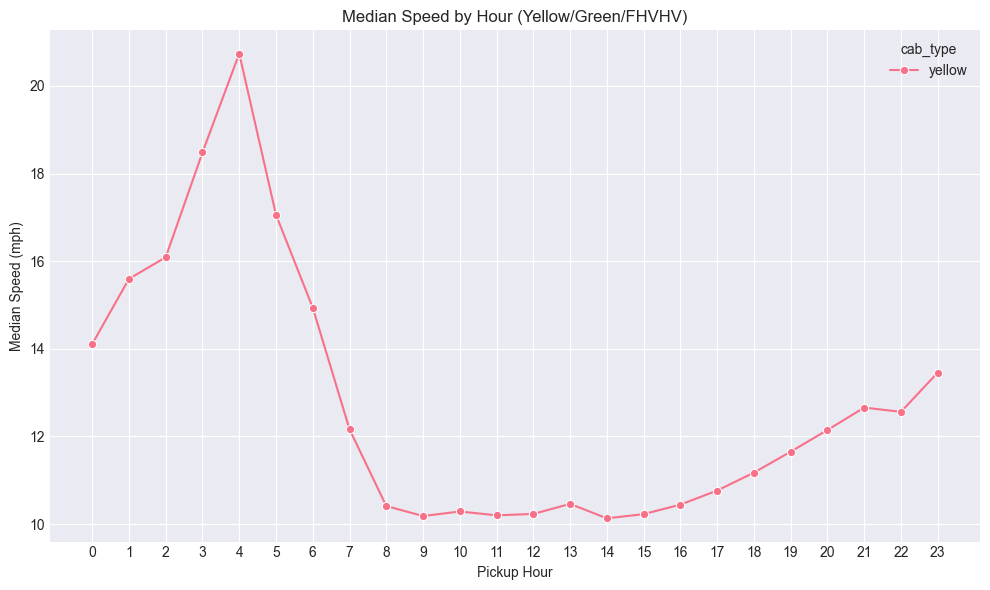

✓ Saved plot to ..\data\local_output\analytics\analysis5_speed_by_hour.png


In [ ]:
if trips_sample.empty or 'hour' not in trips_sample.columns:
    print('Skipping: no data or missing hour')
else:
    ensure_output_dir()
    speed_data = []
    
    # Yellow/Green: compute from trip_distance and pickup/dropoff times
    for cab in ['yellow', 'green']:
        subset = trips_sample[trips_sample['cab_type'] == cab].copy()
        if len(subset) == 0 or 'trip_distance' not in subset.columns:
            continue
        
        # Get dropoff column
        dropoff_col = 'tpep_dropoff_datetime' if cab == 'yellow' else 'lpep_dropoff_datetime'
        pickup_col = 'tpep_pickup_datetime' if cab == 'yellow' else 'lpep_pickup_datetime'
        
        if dropoff_col in subset.columns and pickup_col in subset.columns:
            subset = subset[(subset['trip_distance'] > 0)]
            subset['duration_sec'] = (pd.to_datetime(subset[dropoff_col]) - pd.to_datetime(subset[pickup_col])).dt.total_seconds()
            subset = subset[subset['duration_sec'] > 0]
            subset['speed_mph'] = subset['trip_distance'] / (subset['duration_sec'] / 3600)
            speed_data.append(subset[['cab_type', 'hour', 'speed_mph']])
    
    # FHVHV: use trip_miles and trip_time
    fhvhv_subset = trips_sample[trips_sample['cab_type'] == 'fhvhv'].copy()
    if len(fhvhv_subset) > 0 and 'trip_miles' in fhvhv_subset.columns and 'trip_time' in fhvhv_subset.columns:
        fhvhv_subset = fhvhv_subset[(fhvhv_subset['trip_miles'] > 0) & (fhvhv_subset['trip_time'] > 0)]
        fhvhv_subset['speed_mph'] = fhvhv_subset['trip_miles'] / (fhvhv_subset['trip_time'] / 3600)
        speed_data.append(fhvhv_subset[['cab_type', 'hour', 'speed_mph']])
    
    if not speed_data:
        print('⚠ No distance/duration data (FHV excluded - no distance data)')
    else:
        speed_df = pd.concat(speed_data, ignore_index=True)
        agg = speed_df.groupby(['cab_type', 'hour'])['speed_mph'].median().reset_index()
        plt.figure(figsize=(10,6))
        sns.lineplot(data=agg, x='hour', y='speed_mph', hue='cab_type', marker='o')
        plt.title('Median Speed by Hour (Yellow/Green/FHVHV)')
        plt.xlabel('Pickup Hour')
        plt.ylabel('Median Speed (mph)')
        plt.xticks(range(0,24))
        plt.tight_layout()
        out_path = os.path.join(OUTPUT_DIR, 'analysis5_speed_by_hour.png')
        plt.savefig(out_path)
        plt.show()
        print(f'✓ Saved plot to {out_path}')
        agg.head()

## Analysis 6: Airport Demand Patterns
- Filter trips touching airport zones (JFK/LGA/EWR).
- Show hourly pickup counts and cab-type mix.
- Save stacked line/area-style plot.


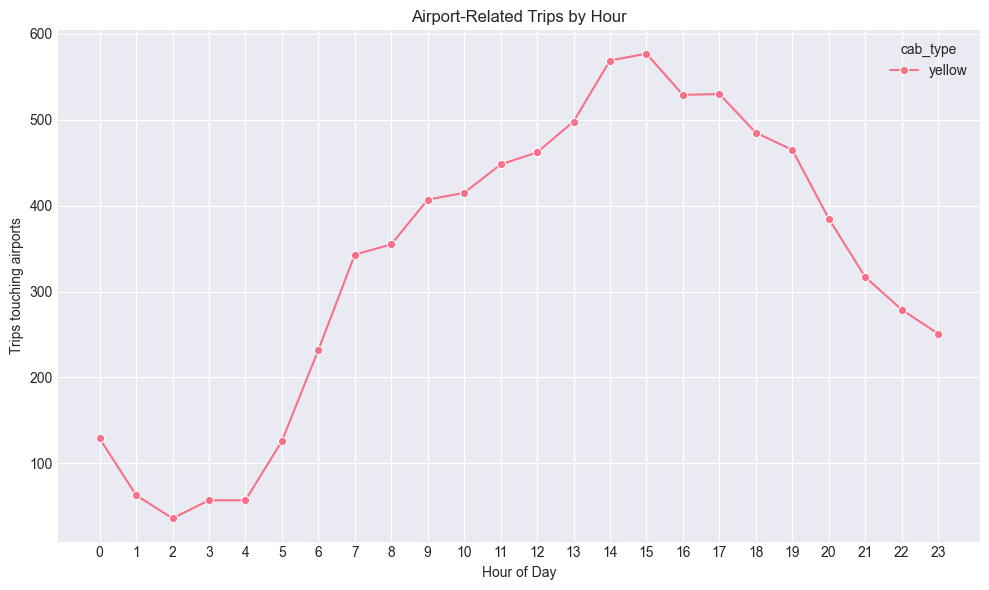

Saved plot to ..\data\local_output\analytics\analysis6_airport_hourly.png


In [ ]:
airport_zones = {132, 138, 1, 140}  # JFK, LGA, EWR, Newark area
if trips_sample.empty or not {'PULocationID', 'DOLocationID', 'hour'}.issubset(trips_sample.columns):
    print('Skipping: missing zone/hour columns or no data')
else:
    ensure_output_dir()
    airport_df = trips_sample[
        trips_sample['PULocationID'].isin(airport_zones) | trips_sample['DOLocationID'].isin(airport_zones)
    ].copy()
    if airport_df.empty:
        print('No airport-touching trips in sample')
    else:
        hourly = airport_df.groupby(['cab_type', 'hour']).size().reset_index(name='trips')
        plt.figure(figsize=(10,6))
        sns.lineplot(data=hourly, x='hour', y='trips', hue='cab_type', marker='o')
        plt.title('Airport-Related Trips by Hour')
        plt.xlabel('Hour of Day')
        plt.ylabel('Trips touching airports')
        plt.xticks(range(0,24))
        plt.tight_layout()
        out_path = os.path.join(OUTPUT_DIR, 'analysis6_airport_hourly.png')
        plt.savefig(out_path)
        plt.show()
        print(f'Saved plot to {out_path}')
        hourly.head()

## Analysis 7: Nightlife Hotspots (Late Hours)
- Filter pickups 8pm–4am.
- Rank top 15 pickup zones for nightlife window.
- Save bar chart to analytics folder.


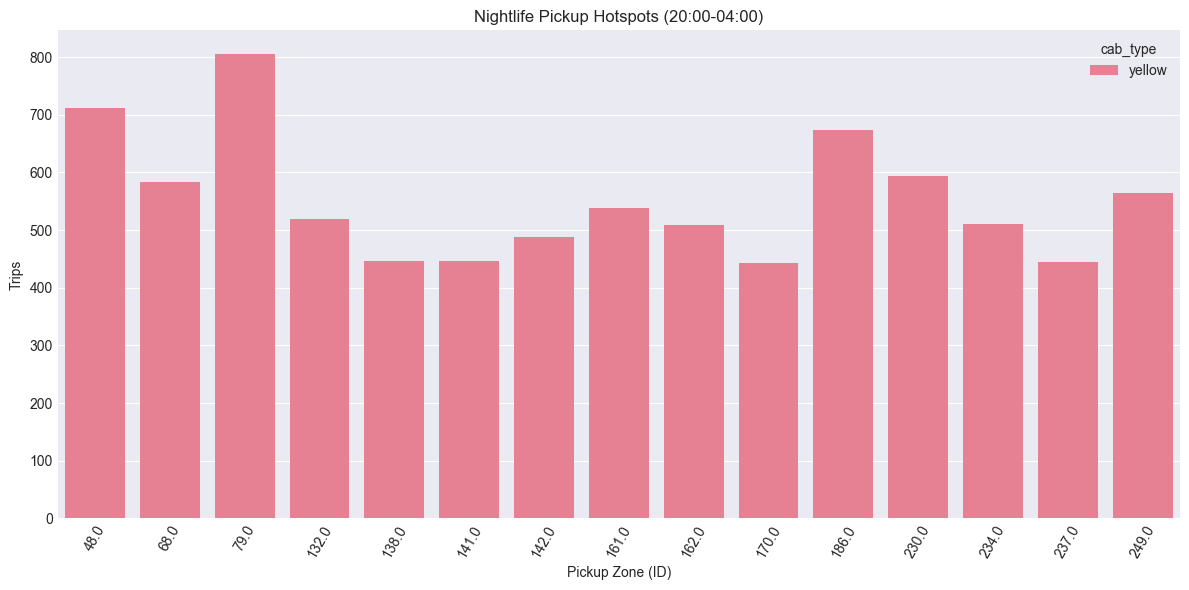

Saved plot to ..\data\local_output\analytics\analysis7_nightlife_hotspots.png


In [ ]:
if trips_sample.empty or not {'hour', 'PULocationID'}.issubset(trips_sample.columns):
    print('Skipping: missing hour/PULocationID or no data')
else:
    ensure_output_dir()
    nightlife_hours = set(range(20, 24)) | set(range(0, 5))
    night_df = trips_sample[trips_sample['hour'].isin(nightlife_hours)].copy()
    if night_df.empty:
        print('No nightlife-window trips in sample')
    else:
        top_night = (
            night_df.groupby(['PULocationID', 'cab_type'])
            .size()
            .reset_index(name='trips')
        )
        top_ids = top_night.groupby('PULocationID')['trips'].sum().nlargest(15).index
        plot_df = top_night[top_night['PULocationID'].isin(top_ids)]
        plt.figure(figsize=(12,6))
        sns.barplot(data=plot_df, x='PULocationID', y='trips', hue='cab_type')
        plt.title('Nightlife Pickup Hotspots (20:00-04:00)')
        plt.xlabel('Pickup Zone (ID)')
        plt.ylabel('Trips')
        plt.xticks(rotation=60)
        plt.tight_layout()
        out_path = os.path.join(OUTPUT_DIR, 'analysis7_nightlife_hotspots.png')
        plt.savefig(out_path)
        plt.show()
        print(f'Saved plot to {out_path}')
        plot_df.head()

## Analysis 8: Outlier Detection (Isolation Forest)
- Use trip_distance, trip_duration_seconds, total_amount as features.
- Flag anomalies per cab type; visualize scatter.
- Save plot to analytics folder.


In [ ]:
if trips_sample.empty:
    print('Skipping: no data')
else:
    ensure_output_dir()
    outlier_data = []
    
    # Yellow/Green: use trip_distance, duration computed, total_amount
    for cab in ['yellow', 'green']:
        subset = trips_sample[trips_sample['cab_type'] == cab].copy()
        if len(subset) == 0:
            continue
        
        dropoff_col = 'tpep_dropoff_datetime' if cab == 'yellow' else 'lpep_dropoff_datetime'
        pickup_col = 'tpep_pickup_datetime' if cab == 'yellow' else 'lpep_pickup_datetime'
        
        if all(c in subset.columns for c in [pickup_col, dropoff_col, 'trip_distance', 'total_amount']):
            subset['duration_sec'] = (pd.to_datetime(subset[dropoff_col]) - pd.to_datetime(subset[pickup_col])).dt.total_seconds()
            subset = subset[(subset['trip_distance'] > 0) & (subset['duration_sec'] > 0) & (subset['total_amount'] > 0)]
            outlier_data.append(subset[['cab_type', 'trip_distance', 'duration_sec', 'total_amount']])
    
    # FHVHV: use trip_miles, trip_time, base_passenger_fare
    fhvhv_subset = trips_sample[trips_sample['cab_type'] == 'fhvhv'].copy()
    if len(fhvhv_subset) > 0 and all(c in fhvhv_subset.columns for c in ['trip_miles', 'trip_time', 'base_passenger_fare']):
        fhvhv_subset = fhvhv_subset[(fhvhv_subset['trip_miles'] > 0) & (fhvhv_subset['trip_time'] > 0) & (fhvhv_subset['base_passenger_fare'] > 0)]
        fhvhv_subset = fhvhv_subset.rename(columns={'trip_miles': 'trip_distance', 'trip_time': 'duration_sec', 'base_passenger_fare': 'total_amount'})
        outlier_data.append(fhvhv_subset[['cab_type', 'trip_distance', 'duration_sec', 'total_amount']])
    
    if not outlier_data:
        print('⚠ No cab types have distance/duration/amount data (FHV excluded)')
    else:
        plot_sample = pd.concat(outlier_data, ignore_index=True).dropna()
        plot_sample = plot_sample.sample(min(len(plot_sample), 5000), random_state=42)
        
        anomalies = []
        for cab, sub in plot_sample.groupby('cab_type'):
            iso = IsolationForest(n_estimators=100, contamination=0.02, random_state=42)
            preds = iso.fit_predict(sub[['trip_distance', 'duration_sec', 'total_amount']])
            tmp = sub.copy()
            tmp['anomaly'] = np.where(preds == -1, 'anomaly', 'normal')
            anomalies.append(tmp)
        
        scored = pd.concat(anomalies, ignore_index=True)
        plt.figure(figsize=(10,6))
        sns.scatterplot(data=scored, x='trip_distance', y='total_amount', hue='anomaly', style='cab_type', alpha=0.6)
        plt.title('Isolation Forest Anomalies (Yellow/Green/FHVHV)')
        plt.xlabel('Trip Distance (miles)')
        plt.ylabel('Total Amount ($)')
        plt.tight_layout()
        out_path = os.path.join(OUTPUT_DIR, 'analysis8_outliers.png')
        plt.savefig(out_path)
        plt.show()
        print(f'✓ Saved plot to {out_path}')
        print(f'\n📊 Anomalies detected: {(scored["anomaly"]=="anomaly").sum()} / {len(scored)}')
        scored['anomaly'].value_counts()

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

## Analysis 9: Trip Pattern Clustering
- Cluster trips by distance, duration, and cost.
- Use KMeans (k=4) on a sample; label clusters.
- Save scatter plot with cluster hues.


In [ ]:
if trips_sample.empty:
    print('Skipping: no data')
else:
    ensure_output_dir()
    cluster_data = []
    
    # Yellow/Green: same as outlier analysis
    for cab in ['yellow', 'green']:
        subset = trips_sample[trips_sample['cab_type'] == cab].copy()
        if len(subset) == 0:
            continue
        
        dropoff_col = 'tpep_dropoff_datetime' if cab == 'yellow' else 'lpep_dropoff_datetime'
        pickup_col = 'tpep_pickup_datetime' if cab == 'yellow' else 'lpep_pickup_datetime'
        
        if all(c in subset.columns for c in [pickup_col, dropoff_col, 'trip_distance', 'total_amount']):
            subset['duration_sec'] = (pd.to_datetime(subset[dropoff_col]) - pd.to_datetime(subset[pickup_col])).dt.total_seconds()
            subset = subset[(subset['trip_distance'] > 0) & (subset['duration_sec'] > 0) & (subset['total_amount'] > 0)]
            cluster_data.append(subset[['cab_type', 'trip_distance', 'duration_sec', 'total_amount']])
    
    # FHVHV
    fhvhv_subset = trips_sample[trips_sample['cab_type'] == 'fhvhv'].copy()
    if len(fhvhv_subset) > 0 and all(c in fhvhv_subset.columns for c in ['trip_miles', 'trip_time', 'base_passenger_fare']):
        fhvhv_subset = fhvhv_subset[(fhvhv_subset['trip_miles'] > 0) & (fhvhv_subset['trip_time'] > 0) & (fhvhv_subset['base_passenger_fare'] > 0)]
        fhvhv_subset = fhvhv_subset.rename(columns={'trip_miles': 'trip_distance', 'trip_time': 'duration_sec', 'base_passenger_fare': 'total_amount'})
        cluster_data.append(fhvhv_subset[['cab_type', 'trip_distance', 'duration_sec', 'total_amount']])
    
    if not cluster_data:
        print('⚠ No cab types have distance/duration/amount (FHV excluded)')
    else:
        cluster_df = pd.concat(cluster_data, ignore_index=True).dropna()
        cluster_df = cluster_df.sample(min(len(cluster_df), 5000), random_state=7)
        
        X = np.log1p(cluster_df[['trip_distance', 'duration_sec', 'total_amount']])
        kmeans = KMeans(n_clusters=4, random_state=7, n_init='auto')
        cluster_df['cluster'] = kmeans.fit_predict(X)
        
        plt.figure(figsize=(10,6))
        sns.scatterplot(data=cluster_df, x='trip_distance', y='total_amount', hue='cluster', style='cab_type', alpha=0.6)
        plt.title('Trip Pattern Clusters (Yellow/Green/FHVHV)')
        plt.xlabel('Trip Distance (miles)')
        plt.ylabel('Total Amount ($)')
        plt.tight_layout()
        out_path = os.path.join(OUTPUT_DIR, 'analysis9_clusters.png')
        plt.savefig(out_path)
        plt.show()
        print(f'✓ Saved plot to {out_path}')
        print(f'\n📊 Cluster distribution:')
        print(cluster_df.groupby('cluster')['trip_distance'].describe()[['count','mean','50%']].to_string())

⚠ No cab types have all required columns (FHV/FHVHV lack fare/distance)


## Analysis 10: Price per Mile vs Hour (Surge-Like Signal)
- Compute unit price = total_amount / trip_distance.
- Track median unit price by hour and cab type.
- Save line chart to analytics folder.


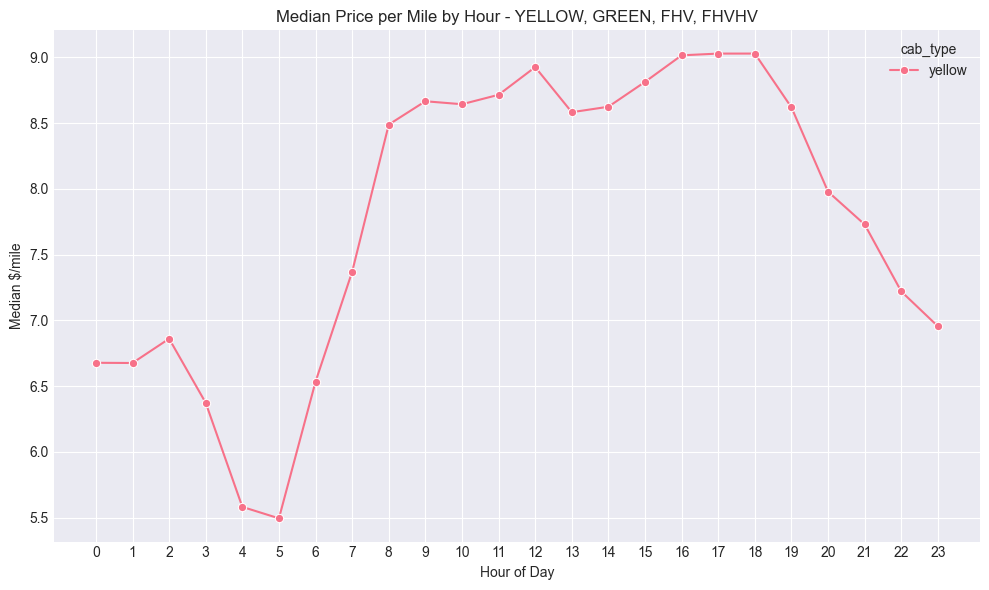

✓ Saved plot to ..\data\local_output\analytics\analysis10_price_per_mile.png (cabs: ['yellow', 'green', 'fhv', 'fhvhv'])


In [ ]:
if trips_sample.empty or 'hour' not in trips_sample.columns:
    print('Skipping: no data or missing hour')
else:
    ensure_output_dir()
    price_data = []
    
    # Yellow/Green: total_amount / trip_distance
    for cab in ['yellow', 'green']:
        subset = trips_sample[trips_sample['cab_type'] == cab].copy()
        if len(subset) > 0 and 'trip_distance' in subset.columns and 'total_amount' in subset.columns:
            subset = subset[(subset['trip_distance'] > 0) & (subset['total_amount'] > 0)]
            subset['unit_price'] = (subset['total_amount'] / subset['trip_distance']).clip(upper=150)
            price_data.append(subset[['cab_type', 'hour', 'unit_price']])
    
    # FHVHV: base_passenger_fare / trip_miles
    fhvhv_subset = trips_sample[trips_sample['cab_type'] == 'fhvhv'].copy()
    if len(fhvhv_subset) > 0 and 'trip_miles' in fhvhv_subset.columns and 'base_passenger_fare' in fhvhv_subset.columns:
        fhvhv_subset = fhvhv_subset[(fhvhv_subset['trip_miles'] > 0) & (fhvhv_subset['base_passenger_fare'] > 0)]
        fhvhv_subset['unit_price'] = (fhvhv_subset['base_passenger_fare'] / fhvhv_subset['trip_miles']).clip(upper=150)
        price_data.append(fhvhv_subset[['cab_type', 'hour', 'unit_price']])
    
    if not price_data:
        print('⚠ No distance/fare data (FHV excluded)')
    else:
        price_df = pd.concat(price_data, ignore_index=True)
        hourly_price = price_df.groupby(['cab_type', 'hour'])['unit_price'].median().reset_index()
        plt.figure(figsize=(10,6))
        sns.lineplot(data=hourly_price, x='hour', y='unit_price', hue='cab_type', marker='o')
        plt.title('Median Price per Mile by Hour (Yellow/Green/FHVHV)')
        plt.xlabel('Hour of Day')
        plt.ylabel('Median $/mile')
        plt.xticks(range(0,24))
        plt.tight_layout()
        out_path = os.path.join(OUTPUT_DIR, 'analysis10_price_per_mile.png')
        plt.savefig(out_path)
        plt.show()
        print(f'✓ Saved plot to {out_path}')
        hourly_price.head()

## Analysis 11: Weather Correlation (if available)
- Check for weather columns (e.g., `temp_f`, `precipitation_inches`).
- Correlate daily trip volume with weather metrics.
- Save scatter/regression plot when data exists.


In [ ]:
weather_cols = ['temp_f', 'precipitation_inches', 'wind_mph', 'snow_inches']
if trips_sample.empty or 'date' not in trips_sample.columns:
    print('Skipping: no date column to aggregate by')
else:
    available_weather = [c for c in weather_cols if c in trips_sample.columns]
    if not available_weather:
        print('Weather columns not found; add weather joins to enable this analysis.')
    else:
        ensure_output_dir()
        daily_trips = trips_sample.groupby('date').size().reset_index(name='trips')
        weather_daily = trips_sample.groupby('date')[available_weather].mean().reset_index()
        merged = pd.merge(daily_trips, weather_daily, on='date', how='inner')
        if merged.empty:
            print('No merged weather rows')
        else:
            metric = available_weather[0]
            plt.figure(figsize=(8,5))
            sns.regplot(data=merged, x=metric, y='trips', scatter_kws={'alpha':0.5})
            plt.title(f'Daily Trips vs {metric}')
            plt.xlabel(metric)
            plt.ylabel('Trips')
            plt.tight_layout()
            out_path = os.path.join(OUTPUT_DIR, 'analysis11_weather_correlation.png')
            plt.savefig(out_path)
            plt.show()
            print(f'Saved plot to {out_path}')
            merged[['date','trips',metric]].head()

Weather columns not found; add weather joins to enable this analysis.


## Analysis 12: Extreme Event Detection by Day
- Flag unusually high/low trip days (volume z-scores).
- Plot top/bottom 5 anomalous dates.
- Save bar chart to analytics folder.


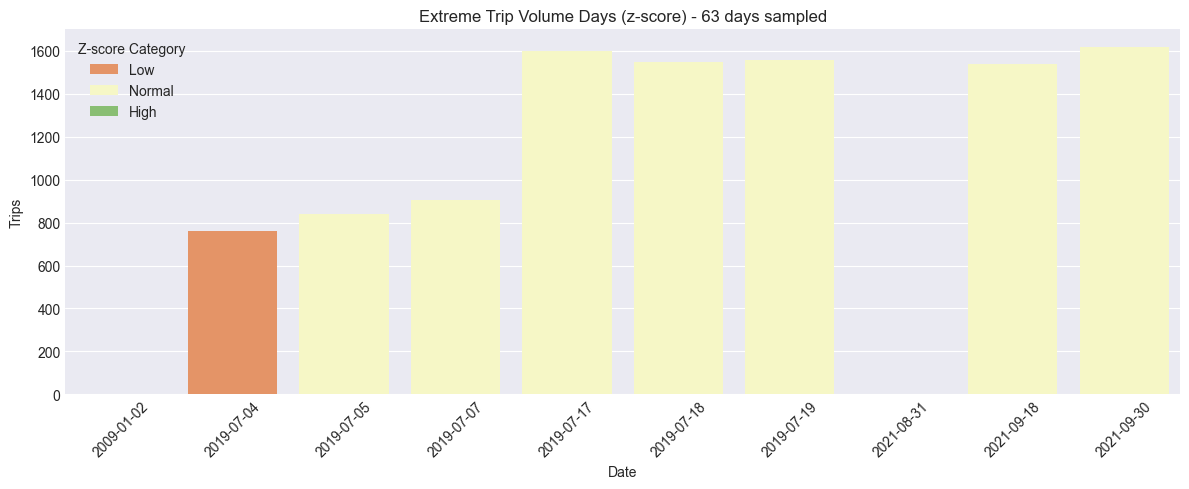

✓ Saved plot to ..\data\local_output\analytics\analysis12_extreme_days.png

📊 Stats: mean=1270, std=294


In [ ]:
if trips_sample.empty or 'date' not in trips_sample.columns:
    print('Skipping: no date column to aggregate by')
else:
    ensure_output_dir()
    daily = trips_sample.groupby('date').size().reset_index(name='trips')
    if daily.empty or len(daily) < 10:
        print(f'⚠ Insufficient daily data ({len(daily)} days); need at least 10 days for z-score analysis')
    else:
        daily['z'] = stats.zscore(daily['trips'])
        top = daily.nlargest(min(5, len(daily)), 'z')
        bottom = daily.nsmallest(min(5, len(daily)), 'z')
        extreme = pd.concat([top, bottom]).drop_duplicates().sort_values('date')
        
        # Create categorical bins for color coding
        extreme['category'] = pd.cut(extreme['z'], 
                                      bins=[-np.inf, -1.5, 1.5, np.inf], 
                                      labels=['Low', 'Normal', 'High'])
        
        plt.figure(figsize=(12,5))
        sns.barplot(data=extreme, x='date', y='trips', hue='category', dodge=False, palette='RdYlGn')
        plt.title(f'Extreme Trip Volume Days (z-score) - {len(daily)} days sampled')
        plt.xlabel('Date')
        plt.ylabel('Trips')
        plt.xticks(rotation=45)
        plt.legend(title='Z-score Category')
        plt.tight_layout()
        out_path = os.path.join(OUTPUT_DIR, 'analysis12_extreme_days.png')
        plt.savefig(out_path)
        plt.show()
        print(f'✓ Saved plot to {out_path}')
        print(f'\n📊 Stats: mean={daily["trips"].mean():.0f}, std={daily["trips"].std():.0f}')
        extreme[['date','trips','z','category']]